In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Ross_Extent = pd.read_excel(filepath, sheet_name='Ross-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Ross_Extent)
fp.date_time(Ross_Extent)

,Extent,Date
0,1040455.516,1979-01-01
1,239334.118,1979-02-01
2,557365.154,1979-03-01
3,2054855.924,1979-04-01
4,2973925.625,1979-05-01
...,...,...
533,3137598.938,2023-06-01
534,3201783.453,2023-07-01
535,2973294.266,2023-08-01
536,3354839.711,2023-09-01


In [5]:
scaler = MinMaxScaler()
Ross_Extent['Extent'] = scaler.fit_transform(Ross_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 9
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Ross_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((518, 12, 1), (518,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Ross_model_LT9/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 35s 439ms/step - loss: 0.2664 - root_mean_squared_error: 0.5162 - val_loss: 0.1060 - val_root_mean_squared_error: 0.3256
Epoch 2/50
53/53 [==============================] - 24s 452ms/step - loss: 0.0715 - root_mean_squared_error: 0.2674 - val_loss: 0.0715 - val_root_mean_squared_error: 0.2674
Epoch 3/50
53/53 [==============================] - 25s 471ms/step - loss: 0.0556 - root_mean_squared_error: 0.2359 - val_loss: 0.0594 - val_root_mean_squared_error: 0.2438
Epoch 4/50
53/53 [==============================] - 26s 495ms/step - loss: 0.0422 - root_mean_squared_error: 0.2055 - val_loss: 0.0450 - val_root_mean_squared_error: 0.2122
Epoch 5/50
53/53 [==============================] - 25s 477ms/step - loss: 0.0311 - root_mean_squared_error: 0.1765 - val_loss: 0.0324 - val_root_mean_squared_error: 0.1799
Epoch 6/50
53/53 [==============================] - 27s 515ms/step - loss: 0.0241 - root_mean_squared_error: 0.1553 - val_loss: 0.0266 

Epoch 30/50
53/53 [==============================] - 27s 509ms/step - loss: 0.0084 - root_mean_squared_error: 0.0917 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0884
Epoch 31/50
53/53 [==============================] - 26s 505ms/step - loss: 0.0088 - root_mean_squared_error: 0.0937 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0827
Epoch 32/50
53/53 [==============================] - 4s 77ms/step - loss: 0.0075 - root_mean_squared_error: 0.0869 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0882
Epoch 33/50
53/53 [==============================] - 4s 77ms/step - loss: 0.0076 - root_mean_squared_error: 0.0874 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0932
Epoch 34/50
53/53 [==============================] - 4s 77ms/step - loss: 0.0076 - root_mean_squared_error: 0.0871 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1149
Epoch 35/50
53/53 [==============================] - 4s 77ms/step - loss: 0.0075 - root_mean_squared_error: 0.0866 - val_loss: 0.0086 - 

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

13.334878655274709 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

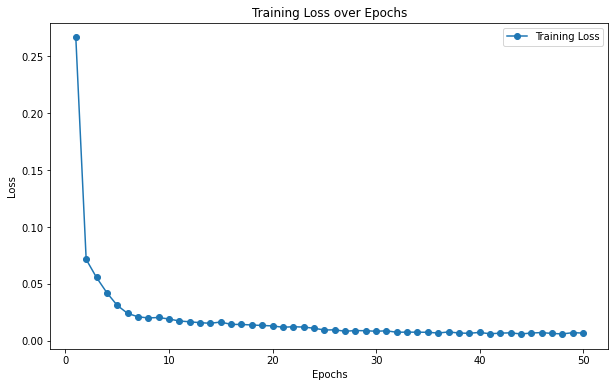

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

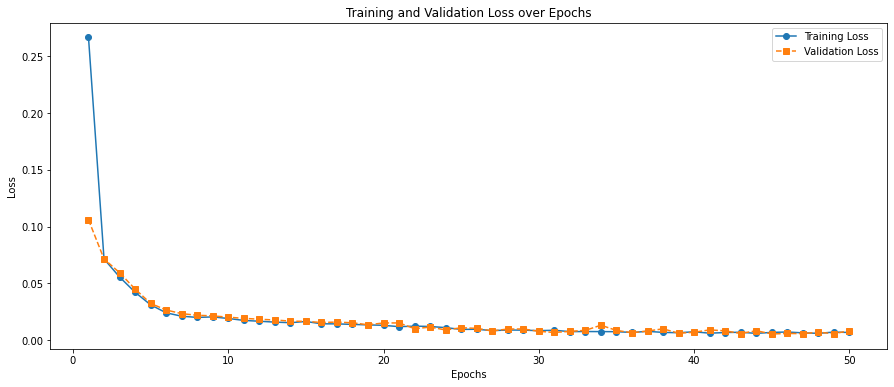

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Ross_model_LT9/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 2s 20ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.08499749618119219
MAE : 0.0676596820195441


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,8.568341e+05,1053272.694
1,2.247627e+05,368862.123
2,5.559294e+05,979418.298
3,1.868189e+06,2086269.569
4,2.643472e+06,2852731.016
5,3.093229e+06,3452823.613
6,3.492678e+06,3846843.974
7,3.767240e+06,4005222.451
8,3.868308e+06,4129684.505
9,3.737572e+06,4130311.577


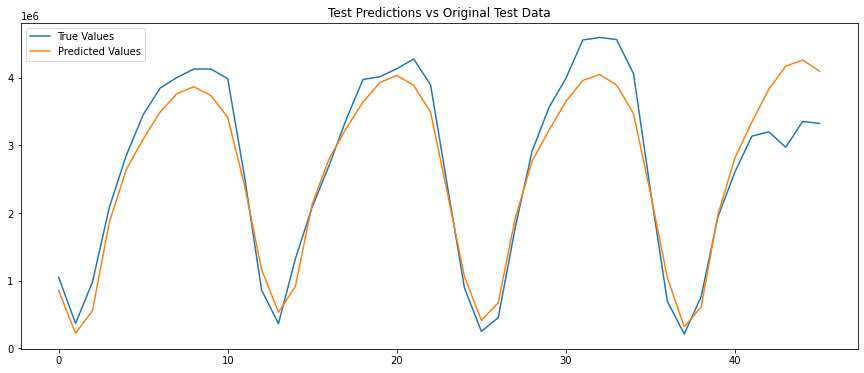

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 1s 31ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

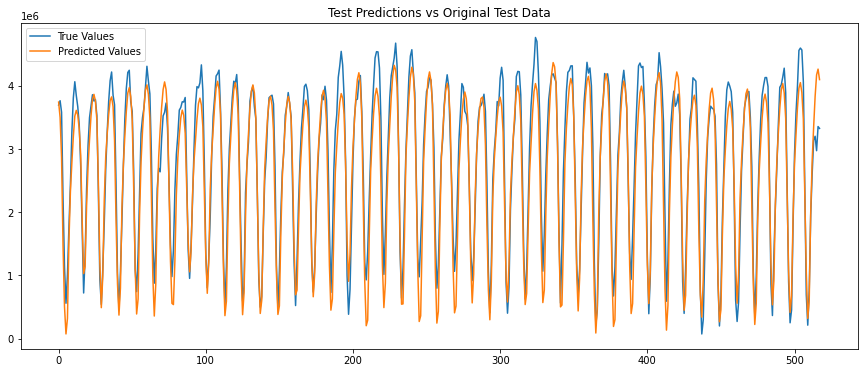

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()